In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd

df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
!pip install lxml
df.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,JS전선,5560,절연선 및 케이블 제조업,"선박선,고무선,전력선,통신선 제조",2007-11-12,12월,이익희,http://www.jscable.co.kr,충청남도
1,거북선2호,101380,NaN,운송장비(선박) 임대,2008-04-25,12월,신주선,NaN,부산광역시
2,거북선6호,114140,NaN,NaN,2009-10-01,12월,김연신,NaN,제주특별자치도
3,교보메리츠,64900,NaN,"부동산 투자,운용",2002-01-30,12월,김 상 진,NaN,서울특별시
4,국제관광공사,28780,NaN,NaN,1966-03-18,12월,NaN,NaN,NaN


# 종목코드 갖고 오기

In [3]:
!pip install pandas_datareader
import pandas_datareader as pdr
yahoo = pdr.get_data_yahoo('000270.KS')
yahoo

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-26,54800.0,53700.0,53700.0,54600.0,837088.0,54600.0
2015-10-27,55300.0,54000.0,54900.0,55100.0,1037136.0,55100.0
2015-10-28,55500.0,54100.0,55500.0,54800.0,762999.0,54800.0
2015-10-29,55300.0,54200.0,54300.0,54800.0,511535.0,54800.0
2015-10-30,55900.0,54300.0,54800.0,55800.0,979684.0,55800.0
...,...,...,...,...,...,...
2020-10-19,47750.0,46600.0,47000.0,46700.0,1536628.0,46700.0
2020-10-20,47150.0,43150.0,43150.0,46850.0,4399855.0,46850.0
2020-10-21,46750.0,45050.0,46550.0,45450.0,2311018.0,45450.0


1. 종목 코드 뽑아내기
2. 종목코드 입력해서 주가 뽑아내기
3. RNN 이용해서 종목 분석
* RNN-이름.ipynb : 메일로 제출
* 추천종목 포함해서 보내세요

In [4]:
# 종목 코드 뽑아내기
new_df = df[['회사명', '종목코드']]
new_df

,회사명,종목코드
0,JS전선,5560
1,거북선2호,101380
2,거북선6호,114140
3,교보메리츠,64900
4,국제관광공사,28780
...,...,...
3874,툴젠,199800
3875,플럼라인생명과학,222670
3876,피엔에이치테크,239890
3877,한국미라클피플사,331660


In [5]:
# rename
rename_df = new_df.rename(columns={'회사명':'name', '종목코드':'code'})
rename_df

,name,code
0,JS전선,5560
1,거북선2호,101380
2,거북선6호,114140
3,교보메리츠,64900
4,국제관광공사,28780
...,...,...
3874,툴젠,199800
3875,플럼라인생명과학,222670
3876,피엔에이치테크,239890
3877,한국미라클피플사,331660


In [6]:
# 회사명으로 코드 검색
def get_code(df, name):
    #code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = rename_df[(rename_df['name'] == name)]['code'].to_string(index=False)
    code = code.strip()
    return code

In [ ]:
# 종목코드 입력해서 주가 뽑아내기(전처리)
rename_df.code = rename_df.code.map('{:06d}'.format)
# code 6자리 맞추기
rename_df

In [11]:
# name
list(df['회사명'])[100:150]

['굿라이프10-MF',
 '글로웍스',
 '네이쳐글로벌',
 '넷컴스토리지',
 '뉴젠아이씨티',
 '뉴켐진스템셀',
 '다임알짜2호-MF',
 '단암산업',
 '대백쇼핑',
 '대신증권그로쓰스팩',
 '데코',
 '동방티엔씨',
 '동아일렉콤',
 '동원뮤추얼장보고1호',
 '드림라인',
 '마이다스코코',
 '맥시스템',
 '모빌탑',
 '무한투자',
 '미래아이티2',
 '미래에셋알바트로스이',
 '미래에셋크린채권형이',
 '미래주식1',
 '미래하이2호',
 '미래하이4',
 '미래한아름2',
 '미주실업',
 '박현주1호',
 '박현주3성장',
 '박현주7성장',
 '베스트플로우',
 '부산방직',
 '비엔디',
 '비엔씨컴퍼니',
 '사라콤',
 '사이노젠',
 '삼능건설',
 '삼성라이프에머랄드일',
 '삼성프라임증권투자회',
 '성보섬유',
 '세븐코스프',
 '세원',
 '세이플러스',
 '스틸플라워',
 '승화프리텍',
 '신텍',
 '신한제4호스팩',
 '신호테크',
 '실크자산2',
 '심스밸리']

In [97]:
# 회사명으로 코드 검색
name = '엔씨소프트'
#rename_df.loc[name]['code'] # 인덱스를 'name'으로 바꿔야함
rename_df[(rename_df['name'] == name)]['code'].to_string(index=False)
code = get_code(rename_df, name) + '.KS'
code
# 이름이 중복 되면 제대로 작동 안함

'036570.KS'

In [98]:
# 종목코드 입력해서 주가 뽑아내기
data = pdr.get_data_yahoo(code) # code = '톨젠'
data
# 야후에 데이터가 없으면 에러

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-26,190000.0,186500.0,189000.0,189500.0,212759.0,181021.031250
2015-10-27,189500.0,185500.0,189500.0,186500.0,203414.0,178155.250000
2015-10-28,187000.0,184000.0,185500.0,185500.0,161507.0,177200.000000
2015-10-29,189500.0,186000.0,186500.0,188500.0,184701.0,180065.765625
2015-10-30,189500.0,184000.0,185500.0,189500.0,198143.0,181021.031250
...,...,...,...,...,...,...
2020-10-19,781000.0,770000.0,774000.0,771000.0,105467.0,771000.000000
2020-10-20,796000.0,773000.0,780000.0,794000.0,147983.0,794000.000000
2020-10-21,813000.0,794000.0,799000.0,809000.0,108005.0,809000.000000


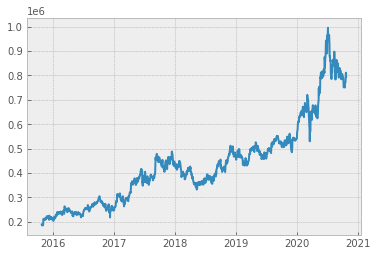

In [99]:
# 시각화
plt.plot(data.index, data["Close"])

In [100]:
cut_line =  int(np.round(data.shape[0] * 0.2))
cut_line

244

In [101]:
# 전처리
x_train = pd.DataFrame(data.Close[:-cut_line])
x_test = pd.DataFrame(data.Close[-cut_line:])
data.shape, x_train.shape, x_test.shape

((1220, 6), (976, 1), (244, 1))

In [102]:
# Scale Data, 정규화 과정
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# MinMaxScaler : 0 ~ 1 사이로 정규화함
scaler.fit(x_train)
s_train = scaler.transform(x_train)
s_test = scaler.transform(x_test)
s_train.shape, s_test.shape

((976, 1), (244, 1))

In [103]:
# time series Generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 50 # 길어질수록 학습의 정확도는 높아짐
ts_train = TimeseriesGenerator(s_train, s_train, length=length, batch_size = 1)
ts_test = TimeseriesGenerator(s_test, s_test, length=length, batch_size = 1)
# stride: 연속되는 출력 시퀀스 사이의 기간. 보폭이 s이면, 연속되는 출력 샘플은 data[i]를 중심으로, data[i+s], data[i+2*s] 등이 됩니다.
# batch_size: 각 배치의 (마지막을 제외한) 시간 단계 샘플의 수.
# length = 50 : 50번째 값을 예측함

In [104]:
# lstm
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(64, input_shape=(length,1), return_sequences=True ))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32))
model_lstm.add(tf.keras.layers.Dense(1))
# 계층을 늘리면 더 좋아진다고 함

In [105]:
model_lstm.compile(optimizer='adam', loss='mse')

In [106]:
model_lstm.fit(ts_train, epochs=6)

Epoch 1/6
926/926 [==============================] - 6s 6ms/step - loss: 0.0033
Epoch 2/6
926/926 [==============================] - 6s 6ms/step - loss: 0.0018
Epoch 3/6
926/926 [==============================] - 6s 6ms/step - loss: 0.0012
Epoch 4/6
926/926 [==============================] - 6s 6ms/step - loss: 0.0012
Epoch 5/6
926/926 [==============================] - 6s 6ms/step - loss: 8.8793e-04
Epoch 6/6
926/926 [==============================] - 6s 6ms/step - loss: 9.8480e-04


In [107]:
# 예측 테스트
p_test_lstm = model_lstm.predict(ts_test)
ts_test[0][0].shape, p_test_lstm.shape

((1, 50, 1), (194, 1))

In [108]:
# 정규화 원상복귀
r_test_lstm = scaler.inverse_transform(p_test_lstm)
# .inverse_transfor : 정규화(0~1) 한 것을 다시 원상 복귀

In [109]:
# x_test 크기 맞추고, 합치기
cut_x_test = x_test.drop(x_test.index[0:length])
cut_x_test['lstm'] = r_test_lstm
cut_x_test

,Close,lstm
Date,,
2020-01-13,614000.0,590021.1250
2020-01-14,610000.0,596827.3750
2020-01-15,619000.0,592538.9375
2020-01-16,632000.0,602550.1250
2020-01-17,631000.0,614677.3125
...,...,...
2020-10-19,771000.0,740826.0625
2020-10-20,794000.0,739086.5625
2020-10-21,809000.0,765601.3750


In [110]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


(array([737425., 737456., 737485., 737516., 737546., 737577., 737607.,
        737638., 737669., 737699., 737730.]),
 <a list of 11 Text major ticklabel objects>)

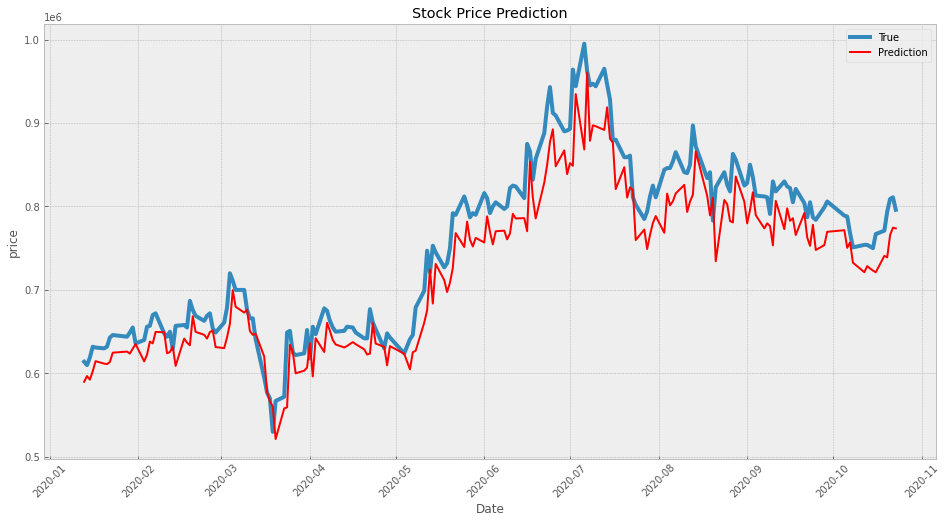

In [111]:
# 시각화
plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('price')
plt.plot(cut_x_test.index, cut_x_test["Close"], linewidth = 4.0, label='True')
plt.plot(cut_x_test.index, cut_x_test.lstm,color='red', linewidth = 2.0, label='Prediction')
plt.legend()
plt.xticks(rotation='45')

# plt.legend(labels=['LSTM'], loc='best')

In [112]:
# 미래 예측
batch = s_test[-length:]

forecast_LSTM = []
c_batch_lstm = batch.reshape((1, length, 1))
num = 6

for i in range(num):
  c_predict_lstm = model_lstm.predict(c_batch_lstm)[0]
  forecast_LSTM.append(c_predict_lstm)
  c_batch_lstm = np.append(c_batch_lstm[:,1:,:], [[c_predict_lstm]], axis=1)

In [113]:
# 정규화 되돌리기
forecast_lstm = scaler.inverse_transform(forecast_LSTM)
forecast_lstm.shape

(6, 1)

In [114]:
# shape 맞추기(숫자로 변환)
reset_df = cut_x_test.reset_index()
forecast_ind = np.arange(reset_df.index[-1], reset_df.index[-1]+num )
reset_df, forecast_ind, forecast_ind.shape

(          Date     Close         lstm
 0   2020-01-13  614000.0  590021.1250
 1   2020-01-14  610000.0  596827.3750
 2   2020-01-15  619000.0  592538.9375
 3   2020-01-16  632000.0  602550.1250
 4   2020-01-17  631000.0  614677.3125
 ..         ...       ...          ...
 189 2020-10-19  771000.0  740826.0625
 190 2020-10-20  794000.0  739086.5625
 191 2020-10-21  809000.0  765601.3750
 192 2020-10-22  811000.0  774589.8125
 193 2020-10-23  796000.0  773763.5000
 
 [194 rows x 3 columns], array([193, 194, 195, 196, 197, 198]), (6,))

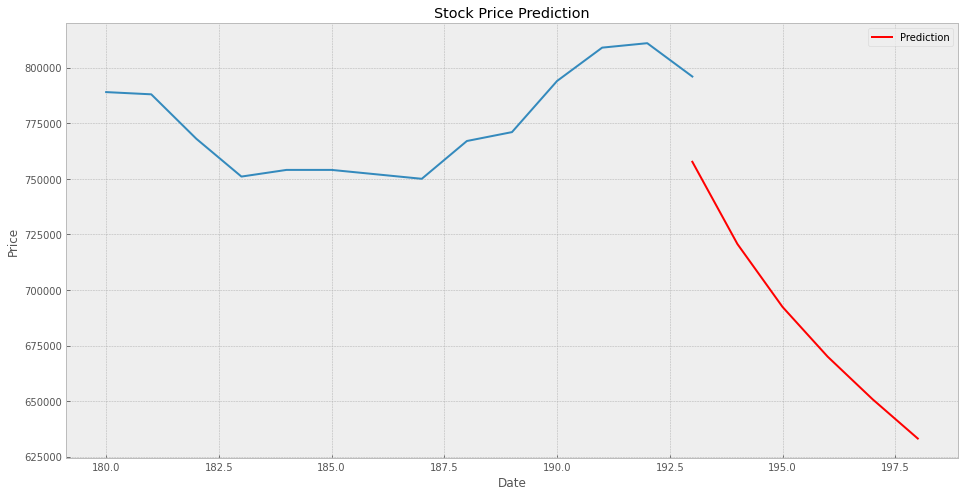

In [115]:
# 시각화
plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(reset_df.index[180:], reset_df["Close"][180:])
plt.plot(forecast_ind, forecast_lstm, color='red',label='Prediction')
plt.legend()

In [ ]:
# shape 맞추기(날짜 그대로)
forecast_idx = np.linspace(0, 1, 365) * (np.datetime64('2021-10-24') - np.datetime64('2020-10-24')) + np.datetime64('2020-10-24')

In [ ]:
# shape 맞추기(날짜 그대로 사용)
forecast_idx = np.linspace(0, 1, 69) * (np.datetime64('2020-12-31') - np.datetime64('2020-10-24')) + np.datetime64('2020-10-24') #change

In [ ]:
reset_df

,Date,Close,lstm
0,2020-01-13,15400.0,16022.560547
1,2020-01-14,15700.0,15733.532227
2,2020-01-15,15600.0,15808.112305
3,2020-01-16,15550.0,15780.575195
4,2020-01-17,15850.0,15739.621094
...,...,...,...
189,2020-10-19,15750.0,16085.870117
190,2020-10-20,15750.0,15980.482422
191,2020-10-21,15800.0,15940.061523
192,2020-10-22,15750.0,15958.112305
